Nome: Lucas Silva Monteiro

NUSP: 10772630

Projeto final - PMT3533 - Termohidráulica de Sistemas de Geração de Potência II (2024)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import iapws as ip
import pandas as pd

Selecione um caso: 1 (operação normal) ou 2 (acidente): 8
Erro: Por favor, insira '1' para operação normal ou '2' para acidente.
Selecione um caso: 1 (operação normal) ou 2 (acidente): 2
Selecione o tempo pós acidente (32 segundos ou 100 segundos): 100
Escolha o número de pontos da Malha: 5
   Centros (mm)    q'' (W/m²)    T4 (°C)    T3 (°C)    T2 (°C)    T1 (°C)  \
0        -240.0   3544.904805  30.103866  31.861120  31.868604  31.992981   
1        -120.0   9280.681266  30.768505  35.290195  35.309787  35.635467   
2           0.0  11471.552923  31.590079  36.999885  37.024102  37.428716   
3         120.0   9280.681266  32.254778  36.563111  36.582704  36.910859   
4         240.0   3544.904805  32.508679  34.160889  34.168372  34.293627   

    h (W/m²·K)  
0  2017.296914  
1  2052.480866  
2  2120.511085  
3  2154.123551  
4  2145.554326  

q_medio = 5993.496824833352 W/m**2
A_total_troca = 32.451840000000004 m**2


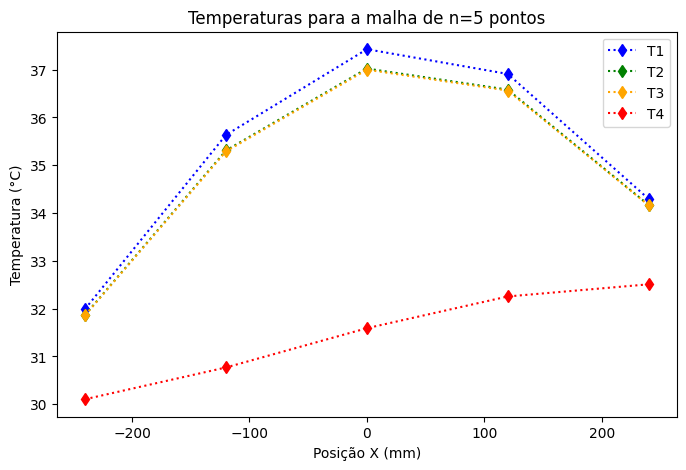

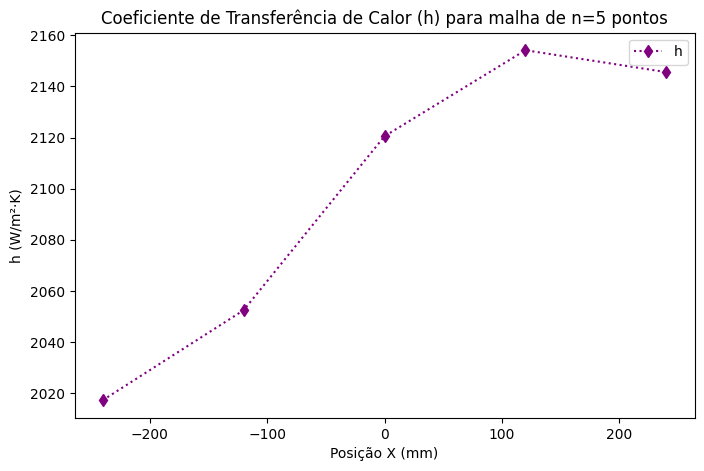

In [25]:
import numpy as np
import iapws as ip
import matplotlib.pyplot as plt
import pandas as pd

# Seleção do caso de operação ou acidente para simulação, verificando se é válido
while True:
    Caso = int(input('Selecione um caso: 1 (operação normal) ou 2 (acidente): '))
    if Caso in [1, 2]:
        break
    else:
        print("Erro: Por favor, insira '1' para operação normal ou '2' para acidente.")

if Caso == 1:
    FP = 1
    fator_vazao = 1
elif Caso == 2:
    while True:
        tempo = int(input('Selecione o tempo pós acidente (32 segundos ou 100 segundos): '))
        if tempo in [32, 100]:
            if tempo == 32:
                FP = 0.05
                fator_vazao = 0.5273
            elif tempo == 100:
                FP = 0.0389
                fator_vazao = 0.1353
            break
        else:
            print("Erro: Por favor, insira '32' ou '100' segundos.")

# Definindo variáveis e constantes usadas no cálculo
FR = 1.914  # Fator radial maior do esquema fornecido
T_ent = 30 + 273  # Temperatura de entrada do fluido em Kelvin
P_reat = FP * 5000000  # Potência do reator em Watts
P_ent = 0.160  # Pressão de entrada (MPa)
P_saida = 0.150  # Pressão de saída (considera perda de carga de 10 kPa)
Vazao_vol_EC = 22.8 * fator_vazao  # Vazão volumétrica por elemento combustível (m³/h)

# Dados geométricos do elemento combustível
N_EC = 24  # Número de elementos combustíveis
N_contr = 1  # Número de elementos de controle
N_placas_comb = 18  # Número de placas combustíveis por elemento
N_placas_contr = 0  # Número de placas de controle

L_placa = 62.6  # Largura da placa combustível (mm)
H_placa = 600  # Altura da placa combustível (mm)
L_canal = 67.1  # Largura do canal (mm)
E_comb = 0.76  # Espessura do combustível (mm)
E_canal_int = 2.89  # Espessura interna do canal de resfriamento (mm)
E_revest = 0.38  # Espessura do revestimento (mm)
k_revest = 180  # Condutividade térmica do revestimento (W/mK)

# Cálculos geométricos e de fluxo de calor
N_total_placa = (N_EC * N_placas_comb) + (N_placas_contr * N_contr)
A_total_troca = N_total_placa * H_placa * (L_placa * 10**-6) * 2  # Área total de troca térmica
A_troca_1_placa = A_total_troca / N_total_placa  # Área de troca térmica por placa
q_2linha_medio = P_reat / A_total_troca  # Fluxo médio de calor por unidade de área
D_h = 4 * (E_canal_int * L_canal) / 10**3 / (2 * E_canal_int + 2 * L_canal)  # Diâmetro hidráulico do canal
A_esc_1_canal = ((E_canal_int * L_canal) * 10**-6)  # Área de escoamento do canal
v_esc = Vazao_vol_EC / ((N_placas_comb - 1) * 3600 * A_esc_1_canal)  # Velocidade de escoamento do fluido no canal
V_total_comb = N_total_placa * E_comb * H_placa * (L_placa * 10**-9)  # Volume total do combustível
q_3linha = P_reat / V_total_comb  # Fluxo volumétrico de calor no combustível

# Funções que calculam propriedades da água em função da temperatura e pressão
def mi1_H2O(T_ent, P_reat):
    # Calcula a viscosidade dinâmica da água
    H2O = ip.IAPWS97(T=T_ent, P=P_reat)
    return H2O.mu

def cp1_H2O(T_ent, P_reat):
    # Calcula o calor específico da água
    H2O = ip.IAPWS97(T=T_ent, P=P_reat)
    return H2O.cp * 1000

def rho1_H2O(T_ent, P_reat):
    # Calcula a densidade da água
    H2O = ip.IAPWS97(T=T_ent, P=P_reat)
    return H2O.rho

def k1_H2O(T_ent, P_reat):
    # Calcula a condutividade térmica da água
    H2O = ip.IAPWS97(T=T_ent, P=P_reat)
    return H2O.k

def h1(k_H2O, Re, Pr):
    # Calcula o coeficiente de transferência de calor por convecção
    return 0.023 * (k_H2O / D_h) * (Re**0.8) * (Pr**0.4)

def Pr(mi_H2O, cp_H2O, k_H2O):
    # Calcula o número de Prandtl do fluido
    return mi_H2O * cp_H2O / k_H2O

def Re(v_esc, rho_H2O, mi_H2O, D_h):
    # Calcula o número de Reynolds do fluido
    return v_esc * rho_H2O * D_h / mi_H2O

def k1_combustivel(T_ent):
    # Calcula a condutividade térmica do combustível
    T = (9 / 5 * T_ent) + 32
    k = 3978.1 / (692.61 + T) + (6.02366 * 10**-12) * ((T + 460)**3)
    return 1.73 * k

def q_1linha(Y):
    # Calcula o fluxo de calor em função da posição axial na placa
    return FR * q_2linha_medio * np.cos((np.pi / 2) * (Y / (H_placa / 2)))

def kelvin_to_celsius(temps):
    # Converte uma lista de temperaturas de Kelvin para Celsius
    return [temp - 273.15 for temp in temps]

# Criando a malha para cálculo dos perfis de temperatura
X_pontos = int(input('Escolha o número de pontos da Malha: '))
Ponto_inicial = - (H_placa / 2) + (H_placa / X_pontos) / 2
Ponto_final = Ponto_inicial + (X_pontos - 1) * (H_placa / X_pontos)
Pontos_Y = np.linspace(Ponto_inicial, Ponto_final, X_pontos)

# Calculando o fluxo de calor por unidade de área ao longo da malha
q_2linha_especifico = np.array([q_1linha(Pontos_Y[i]) for i in range(X_pontos)])

# Obtenção dos perfis de temperatura ao longo do canal e placas combustíveis
Vazao_massica_canal = Vazao_vol_EC * rho1_H2O(T_ent, P_ent) / (3600 * (N_placas_comb - 1))
Grad_pressao = np.linspace(P_ent, P_saida, X_pontos)
A_unid_cont = A_troca_1_placa / X_pontos

# Solução para o fluído refrigerante (T4)
T4 = [0] * X_pontos
T4[0] = T_ent + q_2linha_especifico[0] * A_unid_cont / (Vazao_massica_canal * cp1_H2O(T_ent, Grad_pressao[0]))
for i in range(1, X_pontos):
    cp_H2O = cp1_H2O(T4[i - 1], Grad_pressao[i])
    T4[i] = T4[i - 1] + q_2linha_especifico[i] * A_unid_cont / (Vazao_massica_canal * cp_H2O)
T4C = kelvin_to_celsius(T4)

# Solução para a interface entre o fluido e o revestimento (T3)
T3 = [0] * X_pontos
H = [0] * X_pontos
mi_H2O = mi1_H2O(T4[0], Grad_pressao[0])
rho_H2O = rho1_H2O(T4[0], Grad_pressao[0])
cp_H2O = cp1_H2O(T4[0], Grad_pressao[0])
k_H2O = k1_H2O(T4[0], Grad_pressao[0])
v_esc = (Vazao_massica_canal / rho_H2O) / A_esc_1_canal
re = Re(v_esc, rho_H2O, mi_H2O, D_h)
pr = Pr(mi_H2O, cp_H2O, k_H2O)
h = h1(k_H2O, re, pr)
H[0] = h
T3[0] = T4[0] + q_2linha_especifico[0] / h
for i in range(1, X_pontos):
    mi_H2O = mi1_H2O(T3[i - 1], Grad_pressao[i - 1])
    rho_H2O = rho1_H2O(T3[i - 1], Grad_pressao[i - 1])
    cp_H2O = cp1_H2O(T3[i - 1], Grad_pressao[i - 1])
    k_H2O = k1_H2O(T3[i - 1], Grad_pressao[i - 1])
    v_esc = (Vazao_massica_canal / rho_H2O) / A_esc_1_canal
    re = Re(v_esc, rho_H2O, mi_H2O, D_h)
    pr = Pr(mi_H2O, cp_H2O, k_H2O)
    h = h1(k_H2O, re, pr)
    T3[i] = T4[i] + q_2linha_especifico[i] / h
    H[i] = h
T3C = kelvin_to_celsius(T3)

# Solução para a temperatura do revestimento (T2)
T2 = [T3[i] + q_2linha_especifico[i] * (E_revest / 1000 / k_revest) for i in range(X_pontos)]
T2C = kelvin_to_celsius(T2)

# Solução para a temperatura no centro do combustível (T1)
T1 = [0] * X_pontos
T1[0] = T2[0] + q_2linha_especifico[0] * (E_comb / (2 * 1000)) / (2 * k1_combustivel(T2[0]))
for i in range(1, X_pontos):
    k_combustivel = k1_combustivel(T1[i - 1])
    T1[i] = T2[i] + q_2linha_especifico[i] * (E_comb / (2 * 1000)) / (2 * k_combustivel)
T1C = kelvin_to_celsius(T1)

# Criando a tabela com os resultados calculados
tabela_dados = {
    'Centros (mm)': Pontos_Y,
    'q\'\' (W/m²)': q_2linha_especifico,
    'T4 (°C)': T4C,
    'T3 (°C)': T3C,
    'T2 (°C)': T2C,
    'T1 (°C)': T1C,
    'h (W/m²·K)': H
}

df_tabela = pd.DataFrame(tabela_dados)
print(df_tabela)

print('\nq_medio =', q_2linha_medio, 'W/m**2')
print('A_total_troca =', A_total_troca, 'm**2')

# Gráficos dos perfis de temperatura ao longo da malha
plt.figure(figsize=(8, 5))
plt.plot(Pontos_Y, T1C, ":d", label="T1", color="blue")  # T1 representado em azul
plt.plot(Pontos_Y, T2C, ":d", label="T2", color="green")  # T2 representado em verde
plt.plot(Pontos_Y, T3C, ":d", label="T3", color="orange")  # T3 representado em laranja
plt.plot(Pontos_Y, T4C, ":d", label="T4", color="red")  # T4 representado em vermelho

plt.legend()
plt.title('Temperaturas para a malha de n=' + str(X_pontos) + ' pontos')
plt.xlabel('Posição X (mm)')
plt.ylabel('Temperatura (°C)')
plt.show()

# Gráfico do coeficiente de troca de calor por convecção ao longo da malha
plt.figure(figsize=(8, 5))
plt.plot(Pontos_Y, H, ":d", label="h", color="purple")  # Coeficiente h em roxo
plt.legend()
plt.title('Coeficiente de Transferência de Calor (h) para malha de n=' + str(X_pontos) + ' pontos')
plt.xlabel('Posição X (mm)')
plt.ylabel('h (W/m²·K)')
plt.show()
